In [22]:
import pandas as pd
import numpy as np

### Directory List

In [63]:
input_file_dir = "../dataset/nonfin_2020_2023_striped.csv"
train_data_output_dir = "../train_data/train_data_PT_cabang_237"
model_output_dir = "../models/model_LSTM_PT_cabang_237" # append this with the name of the file

### Input Dataframe

In [24]:
df = pd.read_csv(input_file_dir, delimiter="|", header=0, dtype=str)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15319761 entries, 0 to 15319760
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   dt                 object
 1   trans_type_key     object
 2   trans_lng_nm       object
 3   branch_key         object
 4   sumtrx             object
 5   branch_address1    object
 6   branch_address2    object
 7   region_key         object
 8   jabo_nonjabotabek  object
 9   city_key           object
 10  geography          object
 11  flag_big_city      object
dtypes: object(12)
memory usage: 1.4+ GB


In [26]:
df.head()

,dt,trans_type_key,trans_lng_nm,branch_key,sumtrx,branch_address1,branch_address2,region_key,jabo_nonjabotabek,city_key,geography,flag_big_city
0,2020-10-20,435,Pemesanan Warkat,838,3,SENTRA NIAGA HARAPAN INDAH KAV. CP2 NO.1 KOTA ...,17214,9,J,24,JAKARTA,B
1,2021-04-19,727,Cetak Mutasi Harian,259,2,JL. MUWARDI 1/44,11450,10,J,24,NaN,B
2,2021-05-03,482,Buka Blokir Kartu,1074,2,"KOMP. PERUM TAMAN PALEM LESTARI C5 NO. 9 -11, ...",11730,12,J,24,NaN,B
3,2021-03-08,383,Registrasi m-BCA,196,22,JL. TRUNOJOYO 145,68137,7,N,20,NaN,K
4,2021-11-09,436,Penawaran Solusi,1336,1,"JL. RADEN SALEH NO. 39B, KEL. KARANG MULYA, KE...",15157,12,J,24,NaN,B


### 1.2 Trim dataframe to satisfy LSTM model

In [27]:
row_filter = (df["branch_key"] == "237") & (df["trans_lng_nm"] == "Pemrek Tahapan/Tabunganku")
col_filter = ["dt", "trans_lng_nm", "branch_key", "sumtrx"]
df = df.loc[row_filter, col_filter]

In [28]:
df.head()

,dt,trans_lng_nm,branch_key,sumtrx
6273708,2021-03-01,Pemrek Tahapan/Tabunganku,237,82
6274099,2021-03-25,Pemrek Tahapan/Tabunganku,237,23
6276390,2021-09-08,Pemrek Tahapan/Tabunganku,237,68
6286943,2020-03-20,Pemrek Tahapan/Tabunganku,237,35
6291194,2020-04-16,Pemrek Tahapan/Tabunganku,237,13


#### Final Adjustments
- Adjust Datatypes

In [32]:
df["dt"]                 = pd.to_datetime(df["dt"])
df["trans_lng_nm"]       = df["trans_lng_nm"].astype(str)
df["branch_key"]         = df["branch_key"].astype(np.int32)
df["sumtrx"]             = df["sumtrx"].astype(np.int32)

In [33]:
df

,dt,trans_lng_nm,branch_key,sumtrx
6273708,2021-03-01,Pemrek Tahapan/Tabunganku,237,82
6274099,2021-03-25,Pemrek Tahapan/Tabunganku,237,23
6276390,2021-09-08,Pemrek Tahapan/Tabunganku,237,68
6286943,2020-03-20,Pemrek Tahapan/Tabunganku,237,35
6291194,2020-04-16,Pemrek Tahapan/Tabunganku,237,13
...,...,...,...,...
15197846,2023-03-15,Pemrek Tahapan/Tabunganku,237,59
15199825,2022-07-13,Pemrek Tahapan/Tabunganku,237,87
15201577,2023-05-30,Pemrek Tahapan/Tabunganku,237,72
15223756,2023-02-19,Pemrek Tahapan/Tabunganku,237,24


In [56]:
train_data = df.groupby(["dt"]) \
               .agg({"sumtrx": "sum"}) \
               .sort_values(by=["dt"], ascending=True) \
               .asfreq('D', fill_value=0)
train_data

,sumtrx
dt,
2020-01-02,28
2020-01-03,26
2020-01-04,0
2020-01-05,0
2020-01-06,41
...,...
2023-06-14,48
2023-06-15,44
2023-06-16,44


In [65]:
train_data.to_csv(train_data_output_dir, sep='|')

### 2. Visualization

In [54]:
import matplotlib.pyplot as plt

#### 2.1 Branch 21

Text(0.5, 1.0, 'Trend of sumtrx')

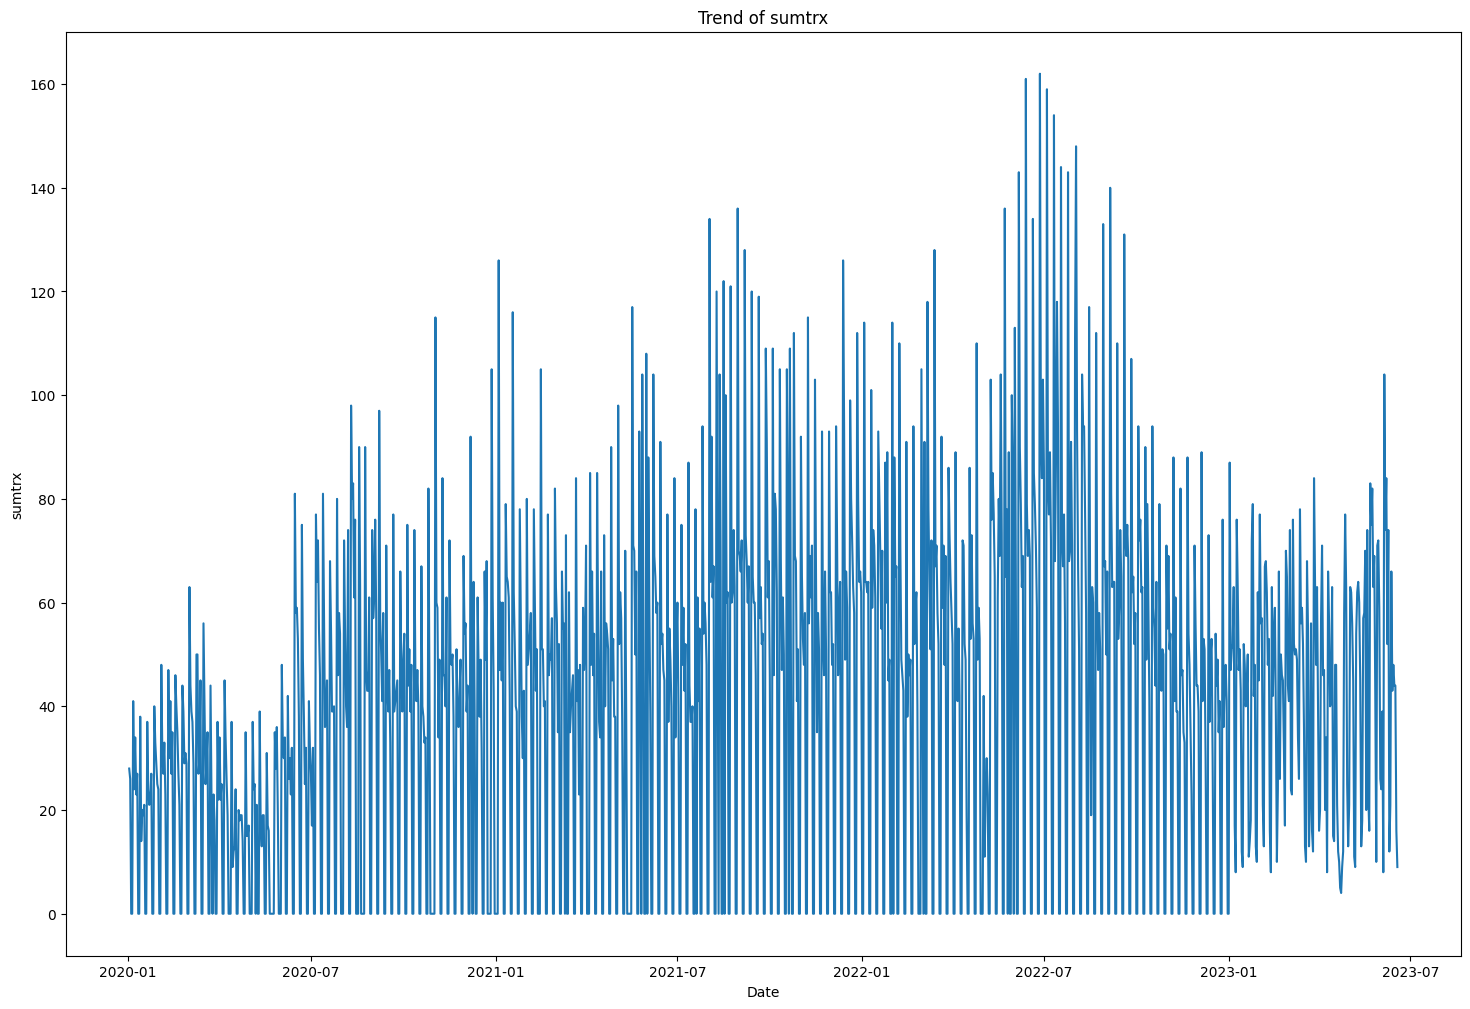

In [57]:
# Membuat grafik
plt.figure(figsize=(18, 12))
plt.plot(train_data.index, train_data['sumtrx'])

# Mengatur label dan judul
plt.xlabel('Date')
plt.ylabel('sumtrx')
plt.title('Trend of sumtrx')

### 3. LSTM Model
- 3.1 Branch 21

In [58]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [59]:
# Mengubah data menjadi skala antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(train_data.values.reshape(-1, 1))

In [31]:
len(scaled_test_data)

77

In [32]:
# Membuat fungsi untuk mengubah data menjadi bentuk yang sesuai untuk LSTM
def create_dataset(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [33]:
# Menentukan jumlah time steps
time_steps = 15

# Membuat dataset latih dan uji
X_train, y_train = create_dataset(scaled_train_data, time_steps)
X_test, y_test = create_dataset(scaled_test_data, time_steps)

# Reshape input menjadi bentuk yang sesuai untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [86]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Melatih model
history = model.fit(X_train, y_train, epochs=5000, batch_size=32)

Epoch 1/5000
10/10 [==============================] - 4s 12ms/step - loss: 0.1173
Epoch 2/5000
10/10 [==============================] - 0s 12ms/step - loss: 0.0997
Epoch 3/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0816
Epoch 4/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0739
Epoch 5/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0718
Epoch 6/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0760
Epoch 7/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0710
Epoch 8/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0737
Epoch 9/5000
10/10 [==============================] - 0s 12ms/step - loss: 0.0710
Epoch 10/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0727
Epoch 11/5000
10/10 [==============================] - 0s 12ms/step - loss: 0.0722
Epoch 12/5000
10/10 [==============================] - 0s 11ms/step - loss: 0.0682
Epoch 13/5000

In [34]:
model = tf.keras.models.load_model(model_output_dir)

In [35]:
# Mengambil nilai loss dari history model
loss = history.history['loss']

# Mengambil nilai epoch
epochs = range(1, len(loss) + 1)

# Memplot grafik loss training
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [36]:
# Melakukan prediksi
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 6ms/step


In [37]:
len(predictions)

62

In [38]:
# Menampilkan hasil prediksi
predicted_data = pd.DataFrame(predictions, columns=['Predicted'], index=test_data_for_branch[21].iloc[:len(predictions)].index)
actual_data = pd.DataFrame(scaler.inverse_transform(scaled_test_data[time_steps:]), columns=['Actual'], index=test_data_for_branch[21].iloc[:len(predictions)].index)
result = pd.concat([actual_data, predicted_data], axis=1)
result

,Actual,Predicted
dt,,
2023-04-02,34.0,26.752932
2023-04-03,32.0,30.037725
2023-04-04,8.0,30.876524
2023-04-05,0.0,27.615261
2023-04-06,0.0,30.301308
...,...,...
2023-05-29,29.0,25.806469
2023-05-30,28.0,21.619646
2023-05-31,27.0,27.523941


In [128]:
test_data_for_branch[21].iloc[:len(predictions), 0].values

array([ 0, 31, 25, 25, 31,  0,  1,  0, 35, 30, 28, 28, 30,  3,  0, 34, 32,
        8,  0,  0,  0,  0,  0,  8, 36, 33, 23,  0,  0,  0, 37, 30, 28, 28,
        1,  0, 37, 24, 28, 29, 34,  1,  0, 37, 30, 34,  0, 26,  4,  0, 31,
       32, 29, 30, 29,  2,  0, 25, 30, 32,  0,  0])

In [136]:
predictions[:, 0].squeeze()

array([26.752932  , 30.037725  , 30.876524  , 27.615261  , 30.301308  ,
        7.8426437 ,  5.29378   , 26.323868  , 33.197403  , 39.18882   ,
       41.857105  , 35.906147  , 29.054409  , 22.237621  , 20.053032  ,
       25.283081  , 16.099857  , 17.737093  , 16.246181  ,  0.13171881,
       -1.3549082 , 12.054708  ,  6.6307096 , 24.278263  , 26.81116   ,
       23.971699  , -0.81567395,  0.30277893, 32.88518   , 20.895967  ,
       20.851877  , 31.944393  , 26.58899   ,  0.78099406,  0.6079629 ,
       20.45716   , 28.724575  , 34.389584  , 32.67322   , 12.996668  ,
       -1.0010623 ,  3.970382  , 23.601093  , 41.190517  , 25.538502  ,
       29.72812   , 29.324108  ,  3.5157573 ,  0.81511587, 23.764984  ,
       26.207996  , 37.53023   , 29.42207   , 21.208899  ,  3.2998133 ,
        1.9109842 , 23.401712  , 25.806469  , 21.619646  , 27.523941  ,
       22.749516  , -0.32841116], dtype=float32)

In [49]:
actual_vs_predicted = pd.DataFrame(
    data={
        "Actual": test_data_for_branch[21].iloc[:len(predictions), 0],
        "Predicted": predictions[:, 0].squeeze()
    }
)
actual_vs_predicted

,Actual,Predicted
dt,,
2023-04-02,0,26.752932
2023-04-03,31,30.037725
2023-04-04,25,30.876524
2023-04-05,25,27.615261
2023-04-06,31,30.301308
...,...,...
2023-05-29,25,25.806469
2023-05-30,30,21.619646
2023-05-31,32,27.523941


In [40]:
from math import sqrt

# Menghitung MSE
rmse = sqrt(mean_squared_error(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"]))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 14.841534506198702


In [41]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 11.244505639518461


In [43]:
def smape(actual, predicted):
    numerator = np.abs(actual - predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    smape_score = np.mean(numerator / denominator) * 100
    return smape_score

In [45]:
smape_score = smape(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"])
print("SMAPE score:", smape_score)

SMAPE score: 99.07267601371278


In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
mape = mean_absolute_percentage_error(actual_vs_predicted["Actual"], actual_vs_predicted["Predicted"])
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): inf


In [147]:
model.save('../models/model_cabang_21.h5')

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Plot Actual vs Predicted

Text(0.5, 1.0, 'Actual vs Predicted')

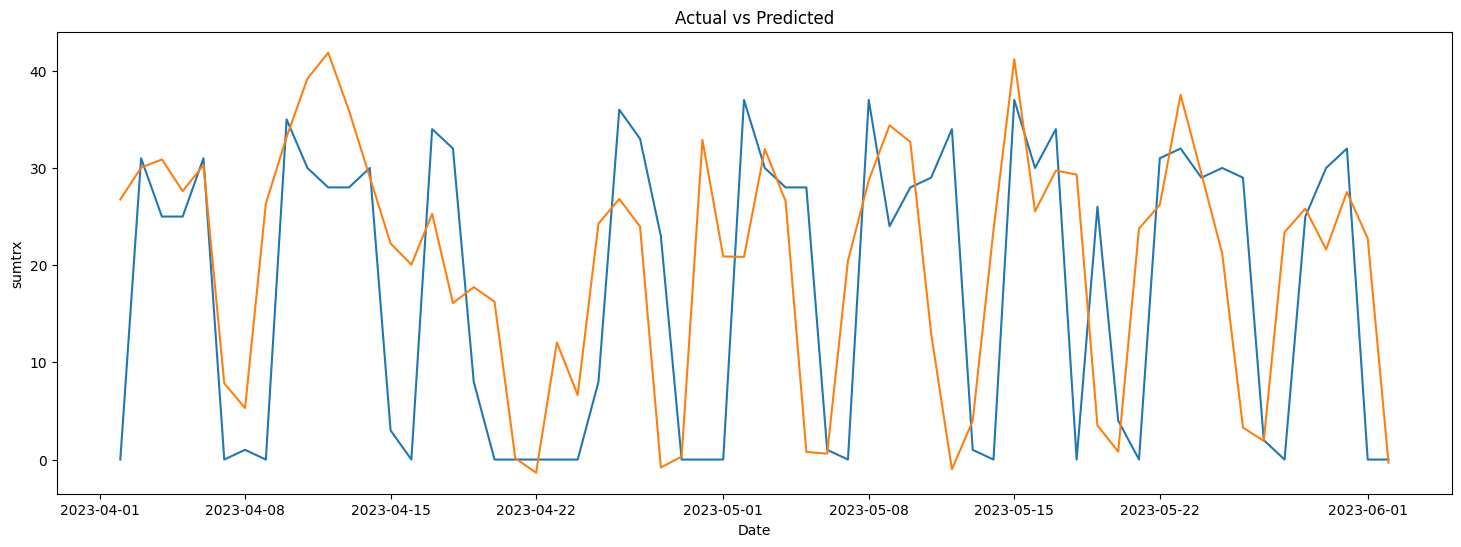

In [148]:
plt.figure(figsize=(18, 6))
plt.plot(actual_vs_predicted.index, actual_vs_predicted["Actual"])
plt.plot(actual_vs_predicted.index, actual_vs_predicted["Predicted"])

# Mengatur label dan judul
plt.xlabel('Date')
plt.ylabel('sumtrx')
plt.title('Actual vs Predicted')